<a href="https://colab.research.google.com/github/crisjosil/MT-PolSAR-Change-Detection-For-Crop-Monitoring-And-Classification/blob/master/AgriSAR_Prediction_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiona
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# python
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.patches as mpatches
from collections import Counter
import fiona
import os
from itertools import product
from __future__ import print_function
from functools import partial
import pandas as pd
import itertools
from google.colab import files
from pickle import dump
from pickle import load
#sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import Normalizer 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

# imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras.backend as K
# Tensor flow
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
tf.test.gpu_device_name()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

2.4.1


''

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
def plot_map_with_legend(lab,values,cmap,crop_typ):       
    plt.figure(figsize=(12,9))
    im = plt.imshow(lab, cmap=cmap,interpolation='none')
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=crop_typ[i] ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(0.85, 1.01), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    plt.axis('off')
    plt.tight_layout()
    
def NN_predict_cube(cube_to_predict_1d,model,labels,title):   
    y_pred_cube_red = np.argmax(model.predict(cube_to_predict_1d), axis=-1)
    y_pred_2d_red = y_pred_cube_red.reshape(labels.shape[0],labels.shape[1])
    y_pred_2d_red=np.where(np.isnan(labels),np.nan,y_pred_2d_red)
    
    fig,(ax1, ax2)=plt.subplots(nrows=1, ncols=2,sharex=True,sharey=True,figsize=(19,9))
    fig.suptitle(title)
    ax1.imshow(labels)
    ax2.imshow(y_pred_2d_red)
    ax1.axis('off')
    ax2.axis('off')
    plt.tight_layout()

# Custom loss function with costs
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in itertools.product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [ ]:
# training labels to create the custom loss funciton and then be able to load the saved model
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/CM/V7/"
layer_name = "y_train_with_diag.npy"
y_train_CM0=np.load(root + layer_name,  allow_pickle=True)

# Determine weight of each class according to number of samples
# For train
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_CM0), y_train_CM0)
class_weight_dict = dict(enumerate(class_weights/class_weights.max())) # normalize the weights to one
sample_weight=np.zeros(y_train_CM0.shape)
for r in np.unique(y_train_CM0):
  sample_weight=np.where(y_train_CM0==r,class_weight_dict[r],sample_weight)

# Array with weights
w_array = np.ones((10,10))
for i in range(10):
  w_array[:,i]=class_weight_dict[i]
for i in range(10):
  w_array[i,i]=1

# name the loss function
ncce = partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

In [ ]:
#Load model
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Datacube/"
save_model_name = "CM_diag_V7_Nadam"
model_CS = load_model(root + save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})

In [ ]:
layer_name = "cube_to_predict_scaled.npy"
cube_to_predict = np.load(root + layer_name,  allow_pickle=True) 
cube_to_predict.shape

(6097142, 147)

In [ ]:
# labels
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Datacube/"
layer_name = "Labels_corrected.npy"#"Areas_asc_FQ2.npy"
print("loading "+layer_name)
Labels=np.load(root+layer_name,  allow_pickle=True)
crop_types = ['Barley','Canary Seed','Canola','Durum wheat','Field Pea','Flax','Lentil','Mixed pasture','Oat','Spring wheat']
values = np.arange(0,10,1) 
#cmap = 'jet'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["pink","green","blue","red","darkviolet","yellow","k","darkorange","lime",'brown'])
#plot_map_with_legend(Labels,values,cmap,crop_types)

loading Labels_corrected.npy


In [ ]:
print("Reshaping as 2d images ...")
cube_to_predict=cube_to_predict.reshape(cube_to_predict.shape[0],7,7,3)
print("Predicting ...")
# y_pred_cube = np.argmax(model_CS.predict(cube_to_predict), axis=-1)
# y_pred_2d = y_pred_cube.reshape(Labels.shape[0],Labels.shape[1])
# y_pred_2d=np.where(np.isnan(Labels),np.nan,y_pred_2d)

# fig,(ax,ax1) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(19,9))
# ax.axis('off')
# ax1.axis('off')
# im = ax.imshow(Labels, cmap=cmap,interpolation='none')
# im1 = ax1.imshow(y_pred_2d, cmap=cmap,interpolation='none')
# # get the colors of the values, according to the 
# # colormap used by imshow
# colors = [ im.cmap(im.norm(value)) for value in values]
# # create a patch (proxy artist) for every color 
# patches = [ mpatches.Patch(color=colors[i], label=crop_types[i] ) for i in range(len(values)) ]
# # put those patched as legend-handles into the legend
# ax.legend(handles=patches, bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.)
# ax1.legend(handles=patches, bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.)
# #plt.grid(True)
# plt.show()
# plt.tight_layout()

Reshaping as 2d images ...
Predicting ...


# Reduced classes

In [ ]:
y_train_red=y_train_CM0.copy() 
y_train_red=np.where(y_train_CM0==0,0,y_train_red) # Barley
y_train_red=np.where(y_train_CM0==1,0,y_train_red) # Canaray seed
y_train_red=np.where(y_train_CM0==2,1,y_train_red) # Canola
y_train_red=np.where(y_train_CM0==3,0,y_train_red) # Durum wheat
y_train_red=np.where(y_train_CM0==4,2,y_train_red) # field Peas 
y_train_red=np.where(y_train_CM0==5,3,y_train_red) # Flax
y_train_red=np.where(y_train_CM0==6,4,y_train_red) # Lentil
y_train_red=np.where(y_train_CM0==7,5,y_train_red) # Mixed Pasture
y_train_red=np.where(y_train_CM0==8,0,y_train_red) # Oat
y_train_red=np.where(y_train_CM0==9,0,y_train_red) # spring wheat

In [ ]:
Labels_red=Labels.copy() 
Labels_red=np.where(Labels==0,0,Labels_red) # Barley
Labels_red=np.where(Labels==1,0,Labels_red) # Canaray seed
Labels_red=np.where(Labels==2,1,Labels_red) # Canola
Labels_red=np.where(Labels==3,0,Labels_red) # Durum wheat
Labels_red=np.where(Labels==4,2,Labels_red) # field Peas 
Labels_red=np.where(Labels==5,3,Labels_red) # Flax
Labels_red=np.where(Labels==6,4,Labels_red) # Lentil
Labels_red=np.where(Labels==7,5,Labels_red) # Mixed Pasture
Labels_red=np.where(Labels==8,0,Labels_red) # Oat
Labels_red=np.where(Labels==9,0,Labels_red) # spring wheat

In [ ]:
# convert class vectors to binary class matrices
print(y_train_red[0])
Y_train_red = np_utils.to_categorical(y_train_red, np.unique(y_train_red).shape[0])
print(Y_train_red[0])

class_weights_red = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_red),
                                                 y_train_red)
class_weight_dict_red = dict(enumerate(class_weights_red/class_weights_red.max())) 
# for test
# sample_weight_test_red=np.zeros(y_test_red.shape)
# for r in np.unique(y_test_red):
#   sample_weight_test=np.where(y_test_red==r,class_weight_dict_red[r],sample_weight_test_red)

# Create an array as big as the training samples.
# To each sample assign a weight depending on its class weight
sample_weight_red=np.zeros(y_train_red.shape) 
# fill the array with a sample weight equal to the class weight
for r in np.unique(y_train_red):
  sample_weight_red=np.where(y_train_red==r,class_weight_dict_red[r],sample_weight_red) 
print(np.unique(sample_weight_red))
print(sample_weight_red.shape)

w_array_red = np.ones((6,6))
for i in range(6):
  w_array_red[:,i]=class_weight_dict_red[i]
for i in range(6):
  w_array_red[i,i]=1

ncce_red = partial(w_categorical_crossentropy, weights=w_array_red)
ncce_red.__name__ ='w_categorical_crossentropy_red'

1.0
[0. 1. 0. 0. 0. 0.]
[0.10154751 0.18489094 0.33461818 0.44688184 0.7257105  1.        ]
(1176829,)


In [ ]:
classes_red = ['Cereals', 'Canola', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture']
values_red = np.arange(0,6,1) 
cmap_red = matplotlib.colors.LinearSegmentedColormap.from_list("", ["limegreen","blue","darkviolet","yellow","k",'darkorange'])#,"k","","lime",'brown'

In [ ]:
#Load model
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Datacube/"
save_model_name = "CM_diag_red_V7_Nadam"
model_CS_red = load_model(root + save_model_name+'.h5', custom_objects={'w_categorical_crossentropy_red': ncce_red})

In [ ]:
y_pred_cube_red = np.argmax(model_CS_red.predict(cube_to_predict), axis=-1)
y_pred_2d_red = y_pred_cube_red.reshape(Labels.shape[0],Labels.shape[1])
y_pred_2d_red=np.where(np.isnan(Labels),np.nan,y_pred_2d_red)

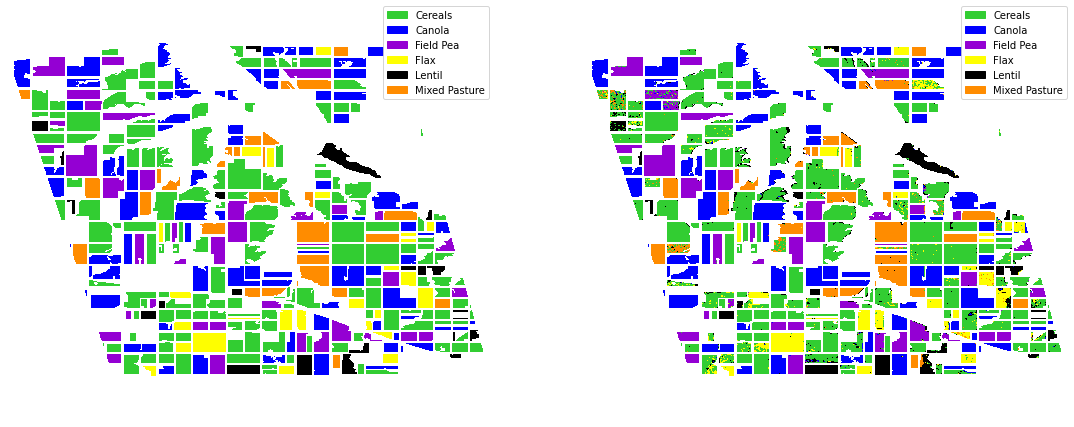

<Figure size 432x288 with 0 Axes>

In [ ]:
fig,(ax,ax1) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(19,9))
ax.axis('off')
ax1.axis('off')
im = ax.imshow(Labels_red, cmap=cmap_red,interpolation='none')
im1 = ax1.imshow(y_pred_2d_red, cmap=cmap_red,interpolation='none')
# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values_red]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=classes_red[i] ) for i in range(len(values_red)) ]
# put those patched as legend-handles into the legend
ax.legend(handles=patches, bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.)
ax1.legend(handles=patches, bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.)
#plt.grid(True)
plt.show()
plt.tight_layout()